# Redes Siamesas: Teoría y Demostración
### Una introducción breve y práctica

## ¿Qué son las redes siamesas?
- Arquitectura diseñada para aprender similitudes entre pares de entradas.
- Introducidas en 1993 para verificación de firmas manuscritas.
- Actualmente, ampliamente usadas en reconocimiento facial, biometría y más.

In [155]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
import tensorflow.keras.backend as K
import random

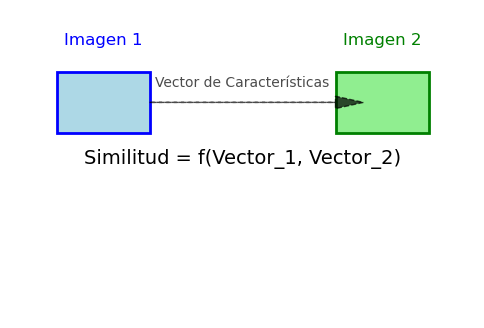

In [95]:
# Configuración del canvas
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Agregar dos cuadros para representar imágenes
rect1 = patches.Rectangle((1, 6), 2, 2, linewidth=2, edgecolor='blue', facecolor='lightblue')
rect2 = patches.Rectangle((7, 6), 2, 2, linewidth=2, edgecolor='green', facecolor='lightgreen')
ax.add_patch(rect1)
ax.add_patch(rect2)

# Etiquetas para las imágenes
ax.text(2, 9, "Imagen 1", ha='center', va='center', fontsize=12, color='blue')
ax.text(8, 9, "Imagen 2", ha='center', va='center', fontsize=12, color='green')

# Dibujar el vector de características
ax.arrow(3, 7, 4, 0, head_width=0.4, head_length=0.6, fc='black', ec='black', linestyle='--', alpha=0.7)
ax.text(5, 7.5, "Vector de Características", ha='center', fontsize=10, color='black', alpha=0.7)

# Simbolizar similitud con ecuación
ax.text(5, 5, "Similitud = f(Vector_1, Vector_2)", ha='center', fontsize=14, color='black')

plt.show()

# Paper origen
- **Título**: "Signature Verification Using a 'Siamese' Time Delay Neural Network".
- **Autores**: Bromley et al.
- **Publicación**: 1993, Advances in Neural Information Processing Systems (NeurIPS).
- **Problema**: ¿Cómo verificar si dos firmas manuscritas son de la misma persona?
- **Solución**: usar dos redes idénticas con pesos compartidos para medir la similitud entre firmas.

## Conceptos Clave
- Las redes siamesas no clasifican directamente; en su lugar, aprenden una métrica de similitud.
- No requeiren un alto volúmen de datos para consturir un buen modelo.

[Paper](https://papers.neurips.cc/paper_files/paper/1993/file/288cc0ff022877bd3df94bc9360b9c5d-Paper.pdf)


## Arquitectura
- Dos redes idénticas con pesos compartidos.
- Salida: vectores de características de las firmas.
- Similitud: calculada con distancia entre vectores (e.g., Euclidiana).

### Función de Pérdida
La función de pérdida contraste se define como:

$$[
L = (1 - y) \cdot \frac{1}{2} (D_W)^2 + y \cdot \frac{1}{2} \max(0, m - D_W)^2
]$$

Donde:
- $( D_W )$: Distancia entre las salidas de las dos redes.
- $( y )$: 1 si las entradas son similares, 0 si no lo son.
- $( m )$: Margen de separación para entradas disimilares.

## Arquitectura y funcionamiento

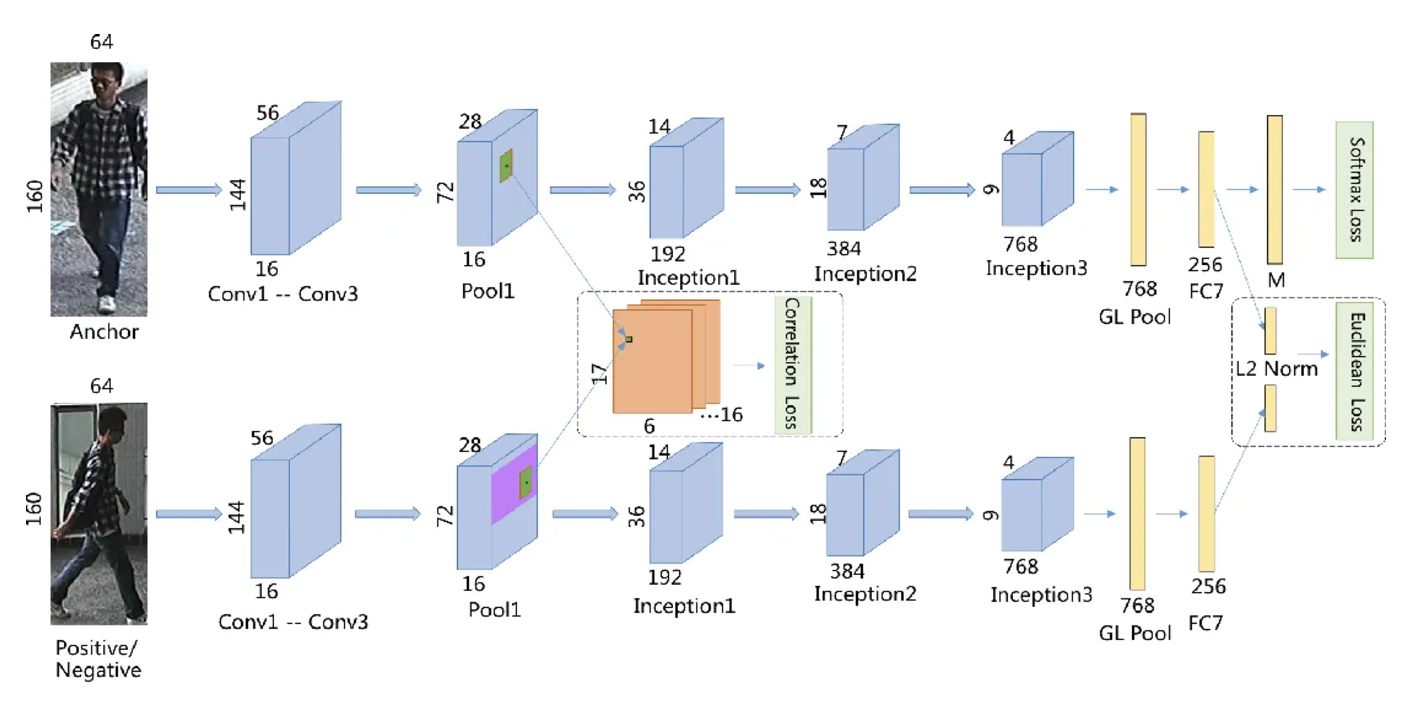

In [159]:
Image.open('siamese_network2.png')

_El modelo toma dos imágenes como entrada y las pasa por redes neuronales idénticas con pesos compartidos. Estas redes extraen vectores de características compactos para cada imagen. Luego, se calcula la similitud entre los vectores usando distancia euclidiana, y el modelo aprende a minimizar la distancia para imágenes similares y maximizarla para diferentes, utilizando funciones de pérdida como Softmax y Euclidean Loss._

### Video explicativo

In [129]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/6jfw8MuKwpI?si=jquhuzAG39-ifcWI" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

### Pros y Contras de las Redes Siamesas

#### **Pros**
1. **Robustez ante desequilibrio de clases**:  
   - Gracias al aprendizaje por "one-shot learning", necesitan pocas imágenes de cada clase para generalizar bien en la clasificación futura.

2. **Ensamblaje con otros clasificadores**:  
   - Pueden combinarse con algoritmos tradicionales (e.g., GBM o Random Forest), logrando mejor desempeño al unir diferentes mecanismos de aprendizaje.

3. **Aprendizaje de similitud semántica**:  
   - Aprenden embeddings que agrupan clases similares en espacios cercanos, permitiendo identificar similitudes semánticas.


#### **Contras**
1. **Tiempo de entrenamiento elevado**:  
   - Necesitan pares cuadráticos para aprender, lo que las hace más lentas que las redes tradicionales o los algoritmos de aprendizaje supervisado.

2. **No generan probabilidades**:  
   - La salida es una distancia entre 0 y 1 (e.g., euclidiana), en lugar de una probabilidad directa.

## Estructura del Dataset

El dataset está organizado en dos carpetas:
- full_forg: Firmas falsificadas.
- full_org: Firmas genuinas.

Cada carpeta contiene 24 firmas por cada uno de los 55 escritores. Los nombres de los archivos identifican al escritor.

In [161]:
# Ruta donde se descargó el dataset
dataset_path = "signatures"
genuine_path = os.path.join(dataset_path, "full_org")
forged_path = os.path.join(dataset_path, "full_forg")


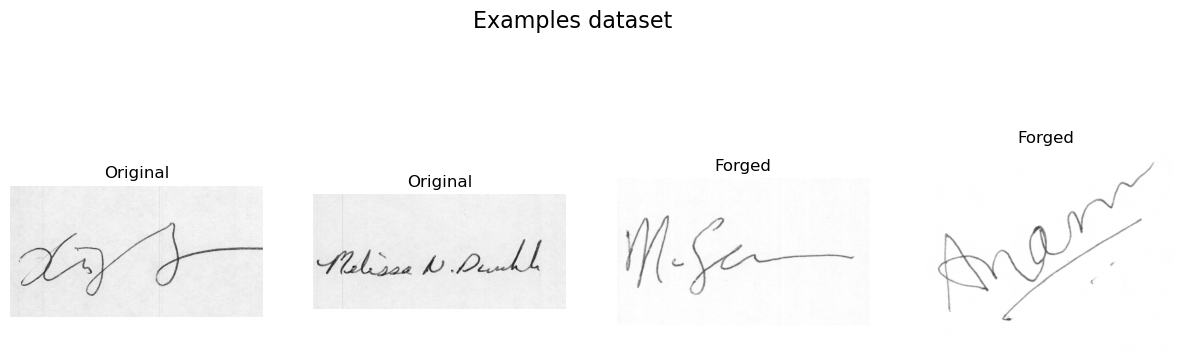

In [170]:
# Función para mostrar firmas aleatorias
def show_random_signatures(org_path, forg_path, num_images=4):
    # Seleccionar imágenes aleatorias de ambas carpetas
    org_images = random.sample(os.listdir(org_path), num_images // 2)
    forg_images = random.sample(os.listdir(forg_path), num_images // 2)

    # Crear una figura
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle("Examples dataset", fontsize=16)

    # Mostrar las imágenes
    for i, img_name in enumerate(org_images + forg_images):
        # Determinar de qué carpeta proviene la imagen
        img_path = os.path.join(org_path if i < num_images // 2 else forg_path, img_name)
        
        # Cargar la imagen
        img = Image.open(img_path)

        # Mostrar la imagen
        axes[i].imshow(img, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title("Original" if i < num_images // 2 else "Forged")
    
    plt.show()

# Mostrar 4 firmas aleatorias (2 genuinas y 2 falsificadas)
show_random_signatures(genuine_path, forged_path, num_images=4)

## Cómo entrenar y cómo probar

In [100]:

# Leer imágenes y crear pares
def load_images(path, resize_shape=(128, 128)):
    images = []
    labels = []
    writers = sorted(set(f.split("_")[0] for f in os.listdir(path)))  # Identificar escritores únicos
    for writer in writers:
        writer_images = [f for f in os.listdir(path) if f.startswith(writer) and f.endswith('.png')]
        for img_name in writer_images:
            img_path = os.path.join(path, img_name)
            img = Image.open(img_path).convert("L")  # Convertir a escala de grises
            img = img.resize(resize_shape)
            images.append(np.array(img) / 255.0)  # Normalizar a [0, 1]
            labels.append(writer)
    return np.array(images), np.array(labels)

# Cargar firmas genuinas y falsificadas
genuine_images, genuine_labels = load_images(genuine_path)
forged_images, forged_labels = load_images(forged_path)

In [104]:
def create_pairs(genuine_images, genuine_labels, forged_images, forged_labels):
    pairs = []
    labels = []

    # Crear pares similares (genuinos)
    for i in range(len(genuine_images) - 1):
        pairs.append([genuine_images[i], genuine_images[i + 1]])
        labels.append(1)  # Etiqueta 1 para similar

    # Crear pares diferentes (genuino vs falsificado)
    for i in range(len(genuine_images)):
        pairs.append([genuine_images[i], forged_images[i]])
        labels.append(0)  # Etiqueta 0 para diferente

    return np.array(pairs), np.array(labels)

pairs, pair_labels = create_pairs(genuine_images, genuine_labels, forged_images, forged_labels)

# Dividir en entrenamiento y prueba
pairs_train, pairs_test, labels_train, labels_test = train_test_split(
    pairs, pair_labels, test_size=0.2, random_state=42
)

In [110]:
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation="relu")(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    return Model(input, x)

input_shape = (128, 128, 1)
base_network = create_base_network(input_shape)

# Entradas
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Embeddings
embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

# Distancia euclidiana
def euclidean_distance(vectors):
    x, y = vectors
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

distance = Lambda(euclidean_distance)([embedding_a, embedding_b])

# Capa final
output = Dense(1, activation="sigmoid")(distance)
siamese_network = Model(inputs=[input_a, input_b], outputs=output)
siamese_network.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  7,391,744 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,391,746 (28.20 MB)

 Trainable params: 7,391,746 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
# Compilar modelo
siamese_network.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Preparar datos
x_train_1 = pairs_train[:, 0].reshape(-1, 128, 128, 1)
x_train_2 = pairs_train[:, 1].reshape(-1, 128, 128, 1)

x_test_1 = pairs_test[:, 0].reshape(-1, 128, 128, 1)
x_test_2 = pairs_test[:, 1].reshape(-1, 128, 128, 1)

# Entrenar
siamese_network.fit(
    [x_train_1, x_train_2], labels_train,
    validation_data=([x_test_1, x_test_2], labels_test),
    batch_size=32,
    epochs=10
)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_7', 'keras_tensor_8']. Received: the structure of inputs=('*', '*')
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - accuracy: 0.5018 - loss: 0.7067 - val_accuracy: 0.5038 - val_loss: 0.6928
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.4985 - loss: 0.6898 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.5539 - loss: 0.6820 - val_accuracy: 0.5019 - val_loss: 0.6952
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.5493 - loss: 0.6745 - val_accuracy: 0.4962 - val_loss: 0.6983
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.5899 - loss: 0.6724 - val_accuracy: 0.5152 - val_loss: 0.7089
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.6042 - loss: 0.6659 - val_accuracy: 0.5095 - val_loss: 0.7079
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.5999 - loss: 0.6552 - val_accuracy: 0.4811 - val_loss: 0.7204
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.6424 - loss: 0.6433 - val_accuracy: 0.465

In [172]:
loss, accuracy = siamese_network.evaluate([x_test_1, x_test_2], labels_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4950 - loss: 0.7734
Loss: 0.7709178328514099, Accuracy: 0.4791666567325592


In [135]:
# Probar un par de firmas
idx = np.random.randint(0, len(pairs_test))
img1 = pairs_test[idx, 0]
img2 = pairs_test[idx, 1]
label = labels_test[idx]

prediction = siamese_network.predict([img1.reshape(1, 128, 128, 1), img2.reshape(1, 128, 128, 1)])[0][0]

print(f"Etiqueta Real: {'Similares' if label == 1 else 'Diferentes'}, Predicción: {prediction:.2f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4950 - loss: 0.7734
Loss: 0.7709178328514099, Accuracy: 0.4791666567325592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Etiqueta Real: Similares, Predicción: 0.55


#### Y is either 1 or 0. If the first image and second image are from the same class, then the value of Y is 0, otherwise, Y is 1

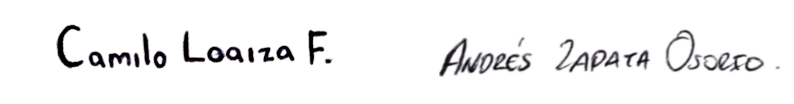

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Etiqueta Real: Diferentes, Predicción: 0.47


In [194]:
# Cargar las imágenes
img1 = Image.open('firma_CamiloLoaiza.png') 
img2 = Image.open('firma_AZ.png') 
fig, axes = plt.subplots(1, 2, figsize=(10, 2))

# Mostrar la imagen
axes[0].imshow(img1, cmap="gray")
axes[0].axis("off")
axes[1].imshow(img2, cmap="gray")
axes[1].axis("off")
plt.show()
# Convertir a escala de grises y redimensionar las imágenes al tamaño esperado (128x128)
img1 = img1.convert('L').resize((128, 128))
img2 = img2.convert('L').resize((128, 128)) 

# Convertir a numpy arrays y escalar los valores de píxeles entre 0 y 1
img1_array = np.array(img1) / 255.0
img2_array = np.array(img2) / 255.0

# Agregar dimensiones necesarias para el modelo
img1_input = img1_array.reshape(1, 128, 128, 1)
img2_input = img2_array.reshape(1, 128, 128, 1)

# Realizar la predicción
prediction = siamese_network.predict([img1_input, img2_input])[0][0]


# Mostrar resultados
label = 0  # Etiqueta real
print(f"Etiqueta Real: {'Similares' if label == 1 else 'Diferentes'}, Predicción: {prediction:.2f}")

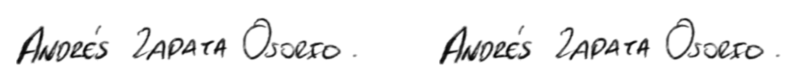

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Etiqueta Real: Similares, Predicción: 0.42


In [188]:
# Cargar las imágenes
img1 = Image.open('firma_AZ.png').convert('L')  # Convertir a escala de grises
img2 = Image.open('firma_AZ.png').convert('L')  # Convertir a escala de grises
fig, axes = plt.subplots(1, 2, figsize=(10, 2))

# Mostrar la imagen
axes[0].imshow(img1, cmap="gray")
axes[0].axis("off")
axes[1].imshow(img2, cmap="gray")
axes[1].axis("off")
plt.show()
# Redimensionar las imágenes al tamaño esperado (128x128)
img1 = img1.resize((128, 128))
img2 = img2.resize((128, 128))

# Convertir a numpy arrays y escalar los valores de píxeles entre 0 y 1
img1_array = np.array(img1) / 255.0
img2_array = np.array(img2) / 255.0

# Agregar dimensiones necesarias para el modelo
img1_input = img1_array.reshape(1, 128, 128, 1)
img2_input = img2_array.reshape(1, 128, 128, 1)

# Realizar la predicción
prediction = siamese_network.predict([img1_input, img2_input])[0][0]

# Mostrar resultados
label = 1  # Etiqueta real
print(f"Etiqueta Real: {'Similares' if label == 1 else 'Diferentes'}, Predicción: {prediction:.2f}")

## Referencias
1. **Artículo de Medium**:  
   Rinkina Gupta, *A Comprehensive Guide to Siamese Neural Networks*, Medium, 2020.  
   Disponible en: [https://medium.com/@rinkinag24/a-comprehensive-guide-to-siamese-neural-networks-3358658c0513](https://medium.com/@rinkinag24/a-comprehensive-guide-to-siamese-neural-networks-3358658c0513)